In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from pybullet_envs.bullet.kukaGymEnv import KukaGymEnv
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import random
import os
from gym import spaces
import time
import pybullet as p
from pybullet_envs.bullet import kuka
import numpy as np
import pybullet_data
import pdb
import distutils.dir_util
import glob
from pkg_resources import parse_version
import gym

current_dir=C:\Users\Kami\anaconda3\envs\robot_grasping\lib\site-packages\pybullet_envs\bullet


In [3]:
env = KukaDiverseObjectEnv(urdfRoot=pybullet_data.getDataPath(),
                           actionRepeat=80,
                           isEnableSelfCollision=True,
                           renders=False,
                           isDiscrete=False,
                           maxSteps=15,
                           dv=0.06,
                           removeHeightHack=False,
                           blockRandom=0.3,
                           cameraRandom=0,
                           width=64,
                           height=64,
                           numObjects=1,
                           isTest=False)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU IS AVAILABLE :D') 
else:  
    device = torch.device("cpu") 
    print('GPU not available')

GPU IS AVAILABLE :D


In [5]:
Transition = namedtuple('Transition',
                       ('state',
                       'action',
                       'next_state',
                       'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        "save a transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [6]:
class DQN(nn.Module):
    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
          
        self.fn1 = nn.Linear(7*7*32, 32)
        
        self.fn2 = nn.Linear(3, 32)
        
        self.fn3 = nn.Linear(32, 32)
        self.fn4 = nn.Linear(32, 1)
        
    def forward(self, s, a): # s is the observation, a is the action 
        s = s.to(device)
        a = a.to(device)
        
        s = F.relu(F.max_pool2d(self.conv1(s), 2))
        s = F.relu(F.max_pool2d(self.conv2(s), 2))
        s = F.relu(F.max_pool2d(self.conv3(s), 2))
        
        s = s.view(-1, 7*7*32) 
        s = F.relu(self.fn1(s))
        
        a = F.relu(self.fn2(a))
        
        val = torch.add(s, a)
        
        val = F.relu(self.fn3(val))
        
        return self.fn4(val)

In [7]:
env.reset()

BATCH_SIZE = 16
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 50

init_screen = env._get_observation()
screen_height, screen_width, _ = init_screen.shape

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict()) 
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayBuffer(50000)

In [15]:
steps_done = 0

In [16]:
import operator

In [17]:
def CrossEntropyMethod(state,
                       sample_fn,
                      objective_fn,
                      update_fn,
                      initial_params,
                      num_elites,
                      num_iterations=1,
                      threshold_to_terminate=None):
    
    updated_params = initial_params
    
    for _ in range(num_iterations):
        samples = sample_fn(**updated_params) # used for dictionaries to give arguments
        
        values = objective_fn(samples, state)
        
        if isinstance(samples, dict):
            sample_order = [i for i, _ in sorted(enumerate(values), key=operator.itemgetter(1))]
           
            sorted_samples = {k: [v[i] for i in sample_order] for k,v in sample.items()}
            
            elite_samples = {k:v[-num_elites:] for k, v in sorted_samples.items()}
            
        else:
            sorted_samples = [s for s, _ in sorted(zip(samples,values), key=operator.itemgetter(1))]
                
            elite_samples = sorted_samples[-num_elites:]
                
        updated_params = update_fn(elite_samples)
            
        if ((threshold_to_terminate is not None) and (max(values) > threshold_to_terminate)):
            break
                
    return samples, values, updated_params

In [18]:
class CEM_policy(object):
    def __init__(self,
                state, 
                batch_size=64,
                action_size=3):
    
        self.batch_size = batch_size
        self._action_size = action_size

        self._action_space = spaces.Box(low=-1, high=1, shape=(3,))
        
    def sample_action(self, state):
            
        def objective_fn(sample, state):
            state = state.tile(64,).reshape(64, 3, 64, 64)
            sample = torch.tensor(sample, dtype=torch.float)
#             print(sample.shape)
            q_values = policy_net(state, sample)
            
            return q_values

        def sample_fn(mean, std):
            return mean + std * np.random.randn(self.batch_size, self._action_size)

        def update_fn(elite_samples):
            return {'mean': np.mean(elite_samples, axis=0),
                   'std': np.std(elite_samples, axis=0, ddof=1)}

        global steps_done
        mu = np.zeros(3)
        mu[2] = -1
        initial_params = {'mean': mu, 'std': .5 * np.ones(3)}
        sample, values, final_params = CrossEntropyMethod(state,
                                                          sample_fn,
                                                         objective_fn,
                                                         update_fn,
                                                         initial_params,
                                                         num_elites=10,
                                                         num_iterations=3)
        
        idx = torch.argmax(values.detach().cpu())
        best_cont_actions, best_cont_vals = sample[idx], values[idx]
        steps_done += 1

        return best_cont_actions

CEM = CEM_policy(env.reset())

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) 
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

#     # error on line below
    state_action_values = policy_net(state_batch, action_batch) #.gather(1, action_batch) 

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # not sure about line below
    next_state_values[non_final_mask] = target_net(non_final_next_states, action_batch).max(1)[0].detach() 
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch 
    
    criterion = nn.SmoothL1Loss() 
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#     '''
#     To get the argmax in the target:
#     sample 16 actions uniformly at random i.e batch_size=16
#     evaluate these actions in the next state (get a vector)
#     pick the one with the largest Q-value (pick the argmax of this vector)'''
    
#     state_action_values = policy_net(state_batch, action_batch)
    
#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     next_state_values[non_final_mask] = target_net(non_final_next_states, action_batch).max(1)[0].detach()
    
#     expected_state_action-values = (next_state_values * GAMMA) + reward_batch
    
#     criterion = nn.SmoothL1Loss()
#     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model 
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [20]:
def get_state(state):
    state = state.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = state.float()
    return state.unsqueeze(0)

In [21]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_durations(): # plotting duration of each episode?
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [22]:
def test(num_episodes=50, max_episode_length=15):
    successes = 0
    for i_episode in range(num_episodes):
        state = env.reset()
        state = get_state(state)
        
        for t in range(max_episode_length):
            action = CEM.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            
            if reward == 1:
                successes += 1
            
            state = get_state(next_state)
            
            if done:
                break
            
    return successes

In [23]:
def Agent(num_episodes=1, max_episode_length=15, save_every=500):
    episode_durations = []
    eps_history = []
    rewards = []
    success_rates = []
    
    for i_episode in range(num_episodes):
        state = env.reset()
        state = get_state(state)
        
        for t in range(max_episode_length):
            action = CEM.sample_action(state)
            next_state, reward, done, _ = env.step(action) #.item())
            
#             if reward == 1:
#                 success_rate += 1
                
            reward = torch.tensor([reward], device=device)
            next_state = get_state(next_state)
            action = torch.tensor(action, dtype=torch.float)
            memory.push(state, action.unsqueeze(0), next_state, reward)
            
            state = next_state
            
            optimize_model()
            
            if done:
                episode_durations.append(t+1)
                break
        
        rewards.append(reward.item())
        
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if i_episode % save_every == 0:
            torch.save(policy_net.state_dict(), 'CEM Optim Policy-net DQN.pt')
            torch.save(target_net.state_dict(), 'CEM Optim Target-net DQN.pt')
        
        if (i_episode + 1) % 125 == 0:
            success_per_1000 = test()
            success_rates.append(success_per_1000)
            print("Episode: ", i_episode + 1, "/", num_episodes, (success_per_1000/50)*100)
    
    final_success = test()
    success_rates.append(final_success)
    
    torch.save(policy_net.state_dict(), 'CEM Optim Policy-net DQN.pt')
    torch.save(target_net.state_dict(), 'CEM Optim Target-net DQN.pt')
    print('Complete')
    return episode_durations, rewards, success_rates

In [24]:
episode_durations, rewards, success_rates = Agent(12500)

Episode:  125 / 12500 0.0
Episode:  250 / 12500 14.000000000000002
Episode:  375 / 12500 8.0
Episode:  500 / 12500 2.0
Episode:  625 / 12500 0.0
Episode:  750 / 12500 0.0
Episode:  875 / 12500 0.0
Episode:  1000 / 12500 4.0
Episode:  1125 / 12500 2.0
Episode:  1250 / 12500 6.0
Episode:  1375 / 12500 10.0
Episode:  1500 / 12500 8.0
Episode:  1625 / 12500 10.0
Episode:  1750 / 12500 6.0
Episode:  1875 / 12500 10.0
Episode:  2000 / 12500 16.0
Episode:  2125 / 12500 10.0
Episode:  2250 / 12500 14.000000000000002
Episode:  2375 / 12500 18.0
Episode:  2500 / 12500 14.000000000000002
Episode:  2625 / 12500 6.0
Episode:  2750 / 12500 12.0
Episode:  2875 / 12500 2.0
Episode:  3000 / 12500 8.0
Episode:  3125 / 12500 8.0
Episode:  3250 / 12500 20.0
Episode:  3375 / 12500 12.0
Episode:  3500 / 12500 6.0
Episode:  3625 / 12500 18.0
Episode:  3750 / 12500 2.0
Episode:  3875 / 12500 6.0
Episode:  4000 / 12500 14.000000000000002
Episode:  4125 / 12500 18.0
Episode:  4250 / 12500 12.0
Episode:  4375 / 

In [25]:
success_percent = (np.array(success_rates)/50) * 100

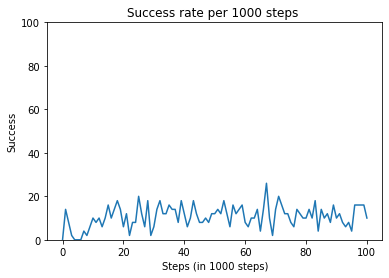

In [28]:
plt.plot(np.arange(len(success_percent)), success_percent)
plt.xlabel('Steps (in 1000 steps)')
plt.ylabel('Success')
plt.title('Success rate per 1000 steps ')
plt.ylim(0,100)
plt.show()